In [194]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster

In [195]:
# Neuron Parameters
neuron_params = {"vThMant": 80,
                 "compartmentVoltageDecay": 128,
                 "compartmentCurrentDecay": 1024,
                 "refractoryDelay": 1}

In [196]:
fc1_weights = np.load("/homes/abdulfatir/quantized-fc1-1000.npy")
fc2_weights = np.load("/homes/abdulfatir/quantized-fc2-1000.npy")

fc1_weights.shape

(4992,)

In [201]:
import glob
from pathlib import Path
ds = "/homes/abdulfatir/data_VT_SNN/"

sample_file = Path(ds) / "test_80_20_1.txt"
samples = np.loadtxt(sample_file).astype("int")
labels = {}
data = {}

for s, l in samples:
    labels[s] = l
    data_loc = Path(ds) / "{}_tact.npy".format(s)
    data[s] = np.load(data_loc).reshape((156,325))

In [202]:
num_steps = 325
input_size = 156
fc1_size = 32
fc2_size = 20

In [205]:
res = {}

for label, spikes in data.items(): 
    net = nx.NxNet()
    cxProto = nx.CompartmentPrototype(functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE, **neuron_params)
    sg = net.createSpikeGenProcess(input_size)
    cxFc1 = net.createCompartmentGroup(size=fc1_size, prototype=cxProto)
    cxFc2 = net.createCompartmentGroup(size=fc2_size, prototype=cxProto)

    # Connect compartment groups
    connProto = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
    sg_fc1 = sg.connect(cxFc1,
                         prototype=connProto,
                         weight=fc1_weights.reshape([fc1_size, input_size]),
                         delay=np.zeros([1,input_size]))
    fc1_fc2 = cxFc1.connect(cxFc2,
                            prototype=connProto,
                            weight=fc2_weights.reshape([fc2_size, fc1_size]),
                            delay=np.zeros([1,fc1_size]))
    # Probes
    (cxFc1UProbe, cxFc1VProbe, cxFc1SProbe) = cxFc1.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                           nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                           nx.ProbeParameter.SPIKE])
    (cxFc2UProbe, cxFc2VProbe, cxFc2SProbe) = cxFc2.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                           nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                           nx.ProbeParameter.SPIKE])
    
    for i in range(156):
        st = np.where(spikes[i,:])[0].tolist()
        sg.addSpikes(spikeInputPortNodeIds=i,
                     spikeTimes=st)
    net.run(num_steps)
    net.disconnect()
    
    output_spikes = np.sum(cxFc2SProbe.data, axis=1)
    predicted = np.argmax(output_spikes)
    res[label] = {"output_spikes": output_spikes,
                  "predicted": predicted}

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:37831
INFO:DRV:      Host server up..............Done 0.36s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
INFO:DRV:      Compiling Embedded snips....Done 1.43s
INFO:DRV:      Encoding probes.............Done 3.23ms
INFO:HST:  Args chip=0 cpu=0 /homes/abdulfatir/loihi/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1584966347.1564949/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.56s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring probes.........Done 8.94ms
INFO:DRV:      Transferring spikes.........Done 0.07s
INFO:DRV:      Executing...................Done 0.16s
INFO:DRV:      Processing timeseries.......Done 0.50s
INFO:DRV:  Executor: 325 timesteps.........Done 5.19s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
INFO:DRV:  SLURM is being run in background

In [209]:
correct = 0
for label, d in res.items():
    correct += labels[label] == d["predicted"]
print(correct / len(res))

0.6333333333333333


# Plots

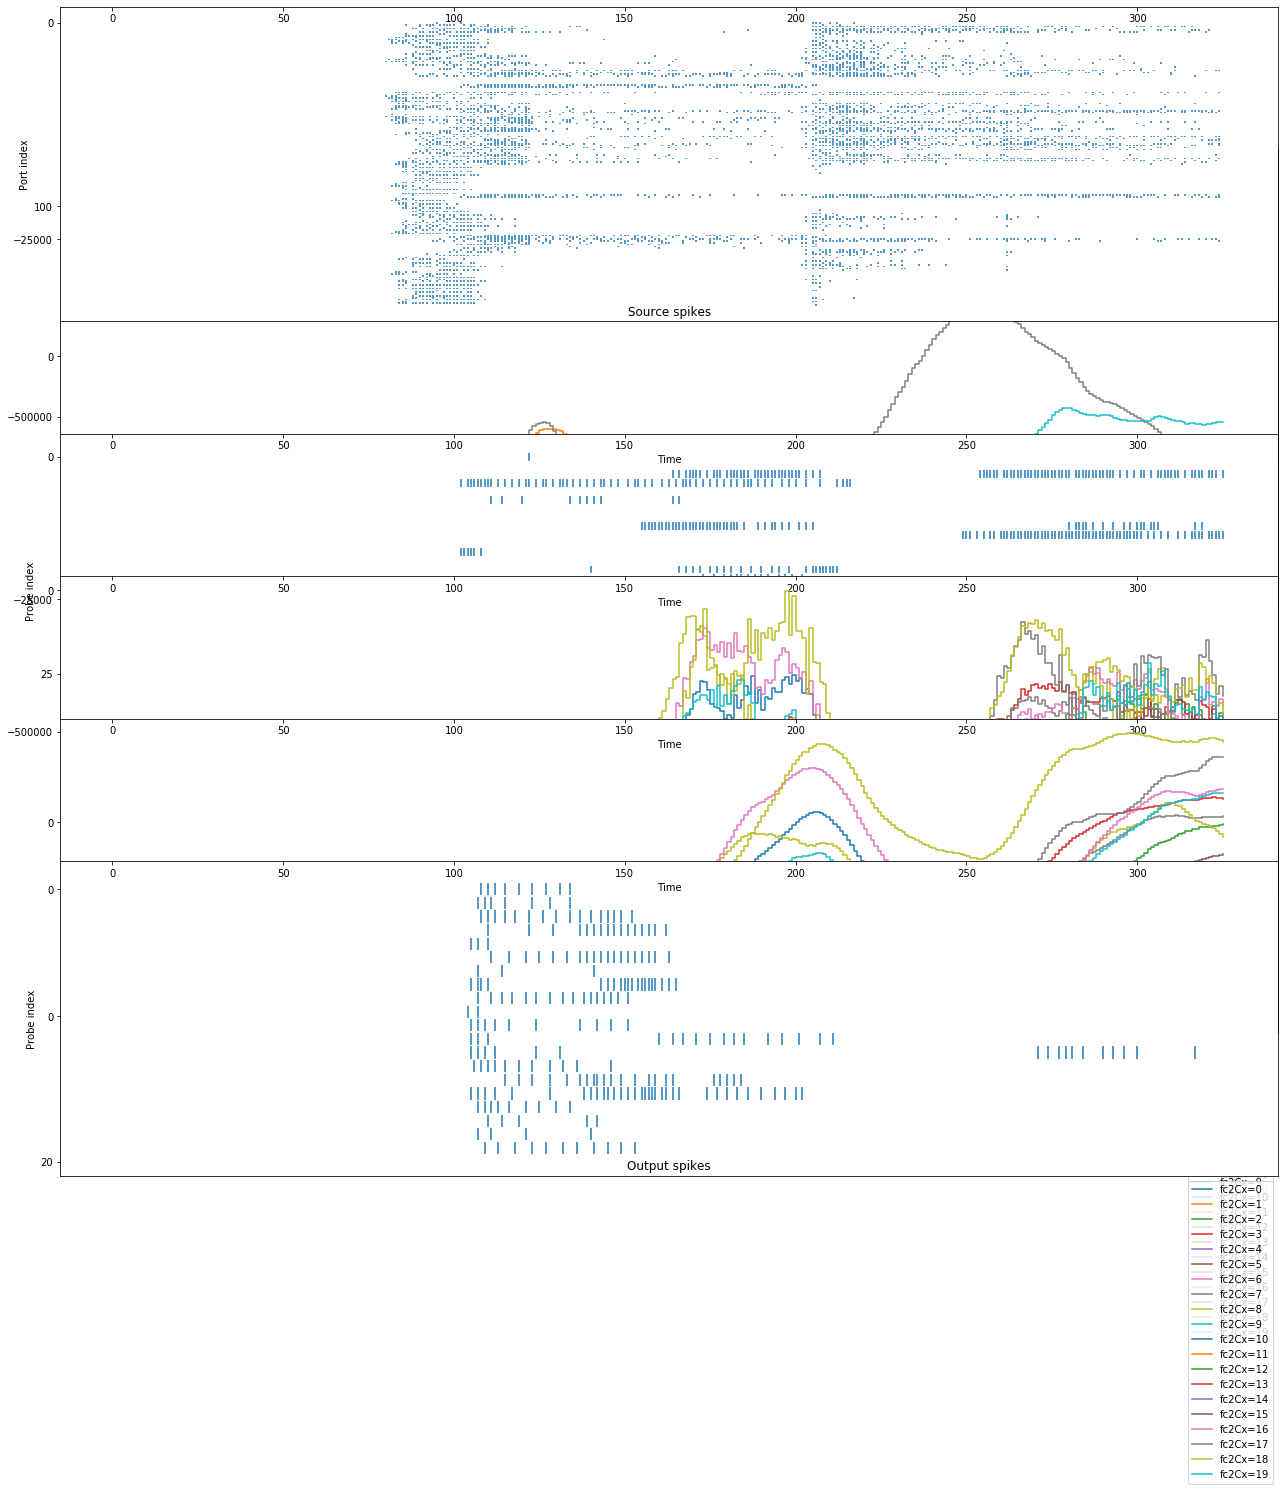

In [210]:
# Plot results
plt.figure(2, figsize=(18,10))

ax1 = plt.subplot(8,1,2)
uh = cxFc1UProbe.plot()
plt.title('FC1 compartmentCurrent')
ax1.legend(uh, ['fc1Cx=%d'%(i) for i in range(len(uh))])

ax2 = plt.subplot(8,1,3)
vh = cxFc1VProbe.plot()
plt.title('FC1 compartmentVoltage')
ax2.legend(uh, ['fc1Cx=%d'%(i) for i in range(len(uh))])

ax3 = plt.subplot(8,1,4)
sh = cxFc1SProbe.plot()
ax3.set_xlim(ax1.get_xlim())
plt.title('FC1 spikes')
ax3.legend(uh, ['fc1Cx=%d'%(i) for i in range(len(uh))])

ax4 = plt.subplot(8,1,5)
uh2 = cxFc2UProbe.plot()
plt.title('Output compartmentCurrent')
ax4.legend(uh, ['fc2Cx=%d'%(i) for i in range(len(uh2))])

ax5 = plt.subplot(8,1,6)
vh2 = cxFc2VProbe.plot()
plt.title('Output compartmentVoltage')
ax5.legend(uh, ['fc2Cx=%d'%(i) for i in range(len(uh2))])

ax6 = plt.subplot(8,1,7)
sh2 = cxFc2SProbe.plot()
ax6.set_xlim(ax4.get_xlim())
plt.title('Output spikes')
ax6.legend(uh, ['fc2Cx=%d'%(i) for i in range(len(uh2))])

ax0 = plt.subplot(8,1,1)
sh = plotRaster(spikeTimes)
ax0.set_xlim(ax4.get_xlim())
plt.ylabel('Port index')
plt.title('Source spikes')
    
plt.tight_layout()
plt.show()